# Wave Period Classifier

In [1]:
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(color_codes=True)
sns.set_context("notebook")
import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell, DropoutWrapper, MultiRNNCell
from natsort import natsorted

from matplotlib import pyplot as plt
%matplotlib inline

## Dataset
Create a dataset of sine waves. Use a list of periods to create wave samples with distinct periods. Randomly assign different amplitudes to each wave.

In [2]:
def create_wave_sample(sample_size, num_points, period, print_stats=False):
    """
    Create a random sample of wave patterns given a sample size, number of points, and a period.
    
    Parameters:
    ----------
    sample_size: int
        Number of wave patterns to create.
    num_points: int
        How many points to use of each wave pattern.
    period: float
        The wave period to use.
    print_stats: bool
        Whether to print statistics and plot for first wave sample. Used for debugging.
        
    Returns:
    -------
    numpy.ndarray
    
    """
    wave_list = []
    count = 1
    for _ in range(sample_size):
        a = np.random.uniform(low=1, high=10.1)
        x = np.linspace(-10*np.pi, 10*np.pi, num_points)
        wave = a*np.sin(period*x)
        wave_and_period = np.insert(float(period), 1, wave)
        wave_list.append(wave_and_period)
        if print_stats:
            print('period: {}'.format(period))
            print('sample size: {}'.format(sample_size))
            print('number of points: {}'.format(num_points))
            print('a: {}'.format(a))
            print('len(x): {}'.format(len(x)))
            print('x range: [{}, {}]'.format(min(x), max(x)))
            print('len(wave_and_period): {}'.format(len(wave_and_period)))
            print('wave range: [{}, {}]'.format(min(wave_and_period), max(wave_and_period)))
            plt.plot(x, wave)
            plt.show()
            print_stats=False
        count += 1
        
    return np.array(wave_list)

Make a list of periods.

In [3]:
periods = [1, 2]

Create wave samples using list of periods.

period: 1
sample size: 150
number of points: 301
a: 9.926390098756544
len(x): 301
x range: [-31.41592653589793, 31.41592653589793]
len(wave_and_period): 302
wave range: [-9.872012295180223, 9.872012295180227]


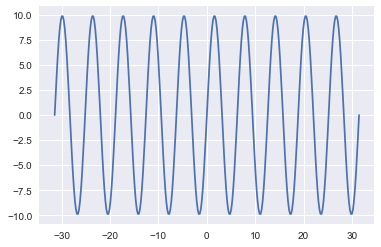

period: 2
sample size: 150
number of points: 301
a: 1.4062045412982491
len(x): 301
x range: [-31.41592653589793, 31.41592653589793]
len(wave_and_period): 302
wave range: [-1.398501205687408, 2.0]


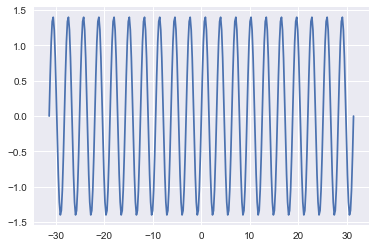

In [4]:
samples_list = []
for i in periods:
    waves = create_wave_sample(150, 301, i, print_stats=True)
    samples_list.append(waves)

Concatenate wave samples into a single sample and load into a DataFrame.

In [5]:
waves_sample = np.concatenate(samples_list)

In [6]:
df = pd.DataFrame(waves_sample)

Randomize the two wave samples by shuffling the DataFrame.

In [ ]:
df_shuffled = df.sample(frac=1).reset_index(drop=True)

#### Dataset Choices:
1. Save the current dataset.
2. Load a saved dataset.
3. Use the currently created dataset.

In [ ]:
SAVE_DATASET = True
LOAD_DATASET = False
waves_filename = os.path.join(os.getcwd(), 'data', 'waves.csv')
if not Path(waves_filename).exists():
    df_shuffled.to_csv(waves_filename, index=False)
    df_dataset = df_shuffled.copy()
if SAVE_DATASET:
    df_shuffled.to_csv(waves_filename, index=False)
    df_dataset = df_shuffled.copy()
elif LOAD_DATASET:
    df_dataset = pd.read_csv(waves_filename)
else:
    df_dataset = df_shuffled.copy()

## Model Preparation

Split dataset into features and labels.

In [ ]:
X_array = df_dataset.iloc[:, 1:].as_matrix()
y_series = df_dataset.iloc[:, 0]

Cast y labels from periods to values between 0 and 1.

In [ ]:
unique_ys = y_series.unique()
sorted_ys = np.sort(unique_ys)
for i in range(len(sorted_ys)):
    y_series = y_series.replace(to_replace=sorted_ys[i], value=i)
new_unique_ys = y_series.unique()
y_array = y_series.values
print('Originals y labels: {}'.format(unique_ys))
print('New y labels: {}'.format(new_unique_ys))

Split features and labels into train and test/validation sets.

In [ ]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

Split test/validation set into test set and validation set.

In [ ]:
test_val_size = int(X_test_val.shape[0] / 2)
X_test = X_test_val[0:test_val_size, :]
y_test = y_test_val[0:test_val_size]
X_val = X_test_val[test_val_size:, :]
y_val = y_test_val[test_val_size:]

Define a function to take random samples of batch size from the training data. This type of training is called bootstrap.

In [ ]:
def make_batch(X, y, batch_size, back_prop_steps):
    """
    Create a random batch from the training data.
    
    Parameters:
    ----------
    X: numpy.ndarray
        Training set.
    y: numpy.ndarray
        Test set.
    batch_size: int
        Batch size.
    back_prop_steps: int
        Back propagation size.
        
    Returns:
    -------
    numpy.ndarray, numpy.ndarray
    
    """
    num_rows, num_columns = X.shape
    bp_start_i = np.random.choice(num_columns-back_prop_steps, 1)[0]
    bp_end_i = bp_start_i + back_prop_steps
    # random_indices = np.random.choice(np.arange(num_rows), batch_size, replace=False)
    random_indices = np.random.randint(low=0, high=len(X), size=batch_size)
    X_batch = X[random_indices, bp_start_i:bp_end_i]
    y_batch = y[random_indices]
    
    return X_batch, y_batch

In [ ]:
# Function to create directories where log file for tensorboard will be stored
def create_log_directory():
    """
    Save log files for tensorboard.
    
    :returns: str
    """
    cwd = os.getcwd()
    if not Path(os.path.join(cwd, 'tmp')).exists():
        os.mkdir(os.path.join(cwd, 'tmp'))
    
    fpath = os.path.join(cwd, 'tmp', 'logs')
    if Path(fpath).exists():
        dirlist = os.listdir(fpath)
        # dirarray_parsed = np.asarray([x.split('_') for x in dirlist])
        dirarray_parsed_prefix = np.asarray([x.split('_')[0] for x in dirlist])
        dirarray_parsed_suffix = np.asarray([x.split('_')[-1] for x in dirlist])
        dirarray_sorted_suffix = natsorted(dirarray_parsed_suffix)
        
        num_run_dirs = np.sum(dirarray_parsed_prefix == 'run')
    else:
        os.mkdir(fpath)
        num_run_dirs = 0
        
    # Check if run_1 directory exists
    if num_run_dirs == 0:
        next_run_dir = 'run_1'
        log_dir = os.path.join('tmp', 'logs', 'run_1')
    else:
        previous_run_num = np.int(dirarray_sorted_suffix[-1])
        next_run = previous_run_num + 1
        next_run_dir = 'run_{}'.format(next_run)
        os.mkdir(os.path.join(fpath, next_run_dir))
        log_dir = os.path.join('tmp', 'logs', 'run_{}'.format(next_run))
    
    print('Tensorboard log files will be saved to {}.'.format(log_dir))
    
    return log_dir

## TensorFlow

In [ ]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

In [ ]:
# Reset graph if session isn't closed
reset_graph()

### Define hyperparameters
Create a dictionary to store the hyperparameters

In [ ]:
hyperparams = {
    'num_classes': len(unique_ys),
    'batch_size': X_train.shape[0] // 10,
    'back_prop_steps': 20,
    'lstm_layers': 2,
    'lstm_cell_units': 5,
    'drop_out': 0.8,
    'clipping_ratio': 5,
    'learning_rate': 5e-4,
    'epochs': 1000
}

### Create Cross Validation Set
Create cross validation dataset of size `batch_size`.

In [ ]:
X_val, y_val = make_batch(X_val, y_val, hyperparams['batch_size'], hyperparams['back_prop_steps'])

### Create Test Set
Create test dataset of size `batch_size`.

In [ ]:
X_test, y_test = make_batch(X_test, y_test, hyperparams['batch_size'], hyperparams['back_prop_steps'])

### Define placeholders

In [ ]:
X_tensor = tf.placeholder(tf.float32, [None, hyperparams['back_prop_steps']], name='Features')
y_tensor = tf.placeholder(tf.int64, [None], name='Labels')
keep_prob = tf.placeholder('float', name='Drop_Out')

### Create the LSTM cell

In [ ]:
def lstm_cell(num_units):
    """
    Create LSTM cell
    
    Parameters:
    ----------
    num_units: int
        Number of units in LSTM cell.
        
    Returns:
    -------
    LSTMCell
    
    """
    cell = LSTMCell(num_units, state_is_tuple=True)
    return cell

In [ ]:
def include_dropout(cell, prob):
    """
    Create dropout wrapper.
    
    Parameters:
    ----------
    cell: LSTMCell
        The LSTM cell.
    prob: float
        Dropout probability.
        
    Returns:
    -------
    DropoutWrapper
    
    """
    cell_culled = DropoutWrapper(cell, input_keep_prob=prob)
    return cell_culled

In [ ]:
def create_multi_cell(num_units, prob, num_layers, batch_size, x):
    """
    Create individual LSTM cells and combine them into a multilayered cell.
    
    Parameters:
    ----------
    num_units: int
        Number of units in LSTM cell.
    num_layers: int
        Number of layers for multilayered cell.
    prob: float
        Dropout probability.
    batch_size: int
        Batch size.
    x: Tensor
        Input tensor of features.
    
    Returns:
    -------
    DropoutWrapper
    
    """
    cell_list = [include_dropout(lstm_cell(num_units), prob) for _ in range(num_layers)]
    multi_cell = MultiRNNCell(cell_list, state_is_tuple=True)
    multi_cell_culled = DropoutWrapper(multi_cell, output_keep_prob=prob)
    initial_state = multi_cell_culled.zero_state(batch_size, tf.float32)
    return multi_cell_culled, initial_state

In [ ]:
def create_rnn(x, cell, initial_state):
    """
    Create the RNN according to the multilayered LSTM cell. Return the last RNN output tensor.
    
    Parameters:
    ----------
    x: Tensor
        Input tensor of features.
    cell: DropoutWrapper
        The multilayered LSTM cell after dropout has been applied.
        
    Returns:
    -------
    Tensor
    
    """
    x_list = tf.unstack(tf.expand_dims(x, axis=2), axis=1)
    outputs, _ = tf.contrib.rnn.static_rnn(cell, x_list, initial_state=initial_state, dtype=tf.float32)
    output = outputs[-1]
    return output

### Create the softmax layer

In [ ]:
def softmax_layer(num_units, num_classes, output):
    """
    Create softmax layer. This is the decision making layer, classifying the wave period for each wave form.
    
    Parameters:
    ----------
    num_units: int
        Number of units in LSTM cell.
    num_classes: int
        Number of periods to classify.
    output: Tensor
        The output tensor from the RNN.
        
    Returns:
    --------
    Tensor
    
    """
    W = tf.Variable(tf.truncated_normal([num_units, num_classes], stddev=1.0),
                   name='weights', dtype=tf.float32, trainable=True)
    b = tf.Variable(tf.zeros([num_classes]),
                   name='biases', dtype=tf.float32, trainable=True)
    output_X_W = tf.matmul(output, W, name='multiply')
    logits = tf.add(output_X_W, b, name='add')
    return logits

### Define the cost function

In [ ]:
def define_cost_function(logits, y, batch_size):
    """
    Define the cost function. In this case, cross entropy.
    
    Parameters:
    ----------
    logits: Tensor
        The output of the softmax layer.
    y: Tensor
        The tensor containing the labels.
    batch_size: int
        Batch size.
    """
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y, name='cross_entropy')
    cost = tf.reduce_sum(loss) / batch_size
    return cost

### Create the training step

In [ ]:
def train(cost, learning_rate, clipping_ratio):
    """
    Function to perform the model training.
    
    Parameters:
    ----------
    cost: Tensor
        The tensor created by the cost function.
    learning_rate: float
        The learning rate.
    clipping_ratio: float
        The ratio of gradients that should be clipped to avoid gradient explosion.
        
    Returns:
    -------
    Operation
    
    """
    training_variables = tf.trainable_variables()
    computed_gradients = tf.gradients(cost, training_variables)
    clipped_gradients, _ = tf.clip_by_global_norm(computed_gradients, clipping_ratio)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = zip(clipped_gradients, training_variables)
    training_step = optimizer.apply_gradients(gradients)
    return training_step

### Check model accuracy

In [ ]:
def compute_accuracy(logits, y):
    """
    Compute model accuracy by comparing logits and input labels.
    
    Parameters:
    ----------
    logits: Tensor
        The output of the softmax layer.
    y: Tensor
        The tensor containing the labels.
        
    Return:
    ------
    Tensor
    
    """
    prediction = tf.equal(tf.argmax(logits, 1), y)
    accuracy = tf.reduce_mean(tf.cast(prediction, 'float'), name='accuracy')
    return accuracy

## Setup the TensorFlow Graph

In [ ]:
# Create LSTM cell
with tf.name_scope("LSTM_cell") as scope:
    cell, initial_state = create_multi_cell(hyperparams['lstm_cell_units'],
                                            keep_prob,
                                            hyperparams['lstm_layers'],
                                            hyperparams['batch_size'],
                                            X_tensor)

# Create RNN
with tf.name_scope("RNN") as scope:
    output = create_rnn(X_tensor, cell, initial_state)

# Create softmax layer
with tf.name_scope("softmax_layer") as scope:
    logits = softmax_layer(hyperparams['lstm_cell_units'],
                          hyperparams['num_classes'],
                          output)
    
# Define cost function
with tf.name_scope("cost_function") as scope:
    cost = define_cost_function(logits, y_tensor, hyperparams['batch_size'])
    tf.summary.scalar("cost", cost)
    
# Define training step
with tf.name_scope("training") as scope:
    training_step = train(cost, hyperparams['learning_rate'], hyperparams['clipping_ratio'])
    
# Calculate cross validation accuracy
with tf.name_scope("accuracy") as scope:
    accuracy = compute_accuracy(logits, y_tensor)
    tf.summary.scalar("accuracy", accuracy)

## Train the model

In [ ]:
# Merge summaries for TensorBoard
merged_summaries = tf.summary.merge_all()

# Start a TensorFlow session
with tf.Session() as sess:
    
    log_directory = create_log_directory()
    summary_writer = tf.summary.FileWriter(log_directory, sess.graph)
    
    tf.global_variables_initializer().run()
    
    step = 0
    for i in range(hyperparams['epochs']):
        # Sample batch for training
        X_batch, y_batch = make_batch(X_train, y_train, 
                                      hyperparams['batch_size'], hyperparams['back_prop_steps'])
        
        # Train the model
        cost_train, _ = sess.run([cost, training_step],
                                feed_dict = {
                                    X_tensor:X_batch,
                                    y_tensor:y_batch,
                                    keep_prob:hyperparams['drop_out']
                                })
        if i%100 == 0:
            
            # Perform cross validation
            result = sess.run([cost, merged_summaries, accuracy],
                             feed_dict = {
                                 X_tensor: X_val,
                                 y_tensor: y_val,
                                 keep_prob: 1
                             })
            cost_val = result[0]
            accuracy_val = result[2]
            training_step_stats = '{:d} of {:d}. Cost: {:0.3f}, CV Cost: {:0.3f}, CV Accuracy: {:0.3f}'.format(i, hyperparams['epochs'], cost_train, cost_val, accuracy_val)
            print(training_step_stats)
            
            # Save model parameters for TensorBoard
            summary_str = result[1]
            summary_writer.add_summary(summary_str, i)
            summary_writer.flush()
            
            step += 1
              
    final_accuracy = sess.run(accuracy,
                          feed_dict = {X_tensor: X_test,
                                       y_tensor: y_test,
                                       keep_prob: 1})
    
    print('The final accuracy is {:3f}.'.format(final_accuracy))
        
             